# Summarizing State of the Union 
From the following url (https://www.whitehouse.gov/briefings-statements/remarks-president-trump-state-union-address-2/), the state of the union is summarized and reduced to the most important sentence.

The preprocessing is done with `Spacy` (https://spacy.io), for graphs we use the `seaborn` package. 
The parsing of the website is achieve using `Beautifulsoup`.

### Loading the different packages

In [17]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [18]:
import pandas as pd
import numpy as np
import string

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [20]:
!pip install beautifulsoup4

In [21]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

### Reading the text

In [22]:
# URL
url="https://www.whitehouse.gov/briefings-statements/remarks-president-trump-state-union-address-2/"

In [23]:
page = urlopen(url)
soup = BeautifulSoup(page, features="lxml")
print('Title:',soup.title.text)
print('There are',len(soup.find_all('p')),'paragraphs in this text')

Title: Remarks by President Trump in State of the Union Address | The White House
There are 158 paragraphs in this text


In [24]:
# Append all the sentences into one long string
text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
print('Nbr Characters:',len(text))

Nbr Characters: 34632


### Pre-Processing
punctuations, lemmatisaton and stopword-removal

In [25]:
punctuations = string.punctuation
print('punctuations:',punctuations)

punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [32]:
stopwords = nlp.Defaults.stop_words
print('Loaded',len(stopwords),'stopwords')

Loaded 305 stopwords


Tokenisation of each sentence.<br>
In the tokenisation every word is reduced to its stem and pronouns (he,she,...) are ignored.

In [33]:
print(text[1000:1100])

to pursue a foreign policy that puts America’s interests first. There is a new opportunity in Americ


In [34]:
doc= nlp(text)

In [35]:
word_list = []
sentence_list = []
for idx, sentence in enumerate(doc.sents):
    tokens = [tok.lemma_.lower().strip() for tok in nlp(str(sentence)) if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    word_list.append(tokens)
    sentence_list.append(str(sentence))


In [43]:
print(word_list[0])
print(sentence_list[0])

['remarks', 'issue', 'february', '6', '2019', 'february', '5', '2019', '9:07', 'p.m.']

				Remarks			 
Issued on:
February 6, 2019
 February 5, 2019
9:07 P.M.


Concentrating data in one single pandas dataframe

In [44]:
df = pd.DataFrame({'sentence':sentence_list,'words':word_list})
df.head()

,sentence,words
0,\n\t\t\t\tRemarks\t\t\t \nIssued on:\nFebruary...,"[remarks, issue, february, 6, 2019, february, ..."
1,EST,[est]
2,"THE PRESIDENT: Madam Speaker, Mr. Vice Presid...","[president, madam, speaker, mr., vice, preside..."
3,(applause),[applause]
4,— and my fellow Americans,"[--, fellow, americans]"


### Featurisation
Split the `doc` object up into different tokens (words)

In [45]:
tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]

Looking at a couple of words

In [46]:
for token in doc[26:30]:
    print(token.text,token.lemma_,token.pos_,token.has_vector)

, , PUNCT True
Mr. mr. PROPN True
Vice vice PROPN True
President president PROPN True


Create a dictionary to keep track of the occurance of a word

In [47]:
word_frequencies = {}  

In [48]:
for word in tokens:
    if word not in word_frequencies.keys():
        word_frequencies[word]=1
    else:
        word_frequencies[word]+=1

In [50]:
word_frequencies['god']

5

In [24]:
words_2_check = ['isis','america','god','hope','bless','democrats','republicans','europe','china']
for w in words_2_check:
    print(w,' -> ', word_frequencies[w], 'times')

isis  ->  2 times
america  ->  26 times
god  ->  5 times
hope  ->  2 times
bless  ->  2 times
democrats  ->  2 times
republicans  ->  2 times
europe  ->  1 times
china  ->  4 times


In [51]:
maximum_frequency = max(word_frequencies.values())
print('max frequency:',maximum_frequency,',total number of words:', len(word_frequencies.values()))

max frequency: 104 ,total number of words: 1271


Transform the frequency in a relative value.

In [52]:
for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
        

In [53]:
maximum_frequency = max(word_frequencies.values())
print('max frequency:',maximum_frequency)

max frequency: 1.0


### Summarize the text

In [54]:
df['score'] = df['words'].apply(lambda x : np.sum([np.sum(word_frequencies[w]) for w in x]))

In [55]:
df.head()

,sentence,words,score
0,\n\t\t\t\tRemarks\t\t\t \nIssued on:\nFebruary...,"[remarks, issue, february, 6, 2019, february, ...",0.211538
1,EST,[est],0.019231
2,"THE PRESIDENT: Madam Speaker, Mr. Vice Presid...","[president, madam, speaker, mr., vice, preside...",1.125000
3,(applause),[applause],1.000000
4,— and my fellow Americans,"[--, fellow, americans]",0.557692


In [56]:
idx = df['score']!=0
df = df.loc[idx,:].copy()

In [57]:
df.head()

,sentence,words,score
0,\n\t\t\t\tRemarks\t\t\t \nIssued on:\nFebruary...,"[remarks, issue, february, 6, 2019, february, ...",0.211538
1,EST,[est],0.019231
2,"THE PRESIDENT: Madam Speaker, Mr. Vice Presid...","[president, madam, speaker, mr., vice, preside...",1.125000
3,(applause),[applause],1.000000
4,— and my fellow Americans,"[--, fellow, americans]",0.557692


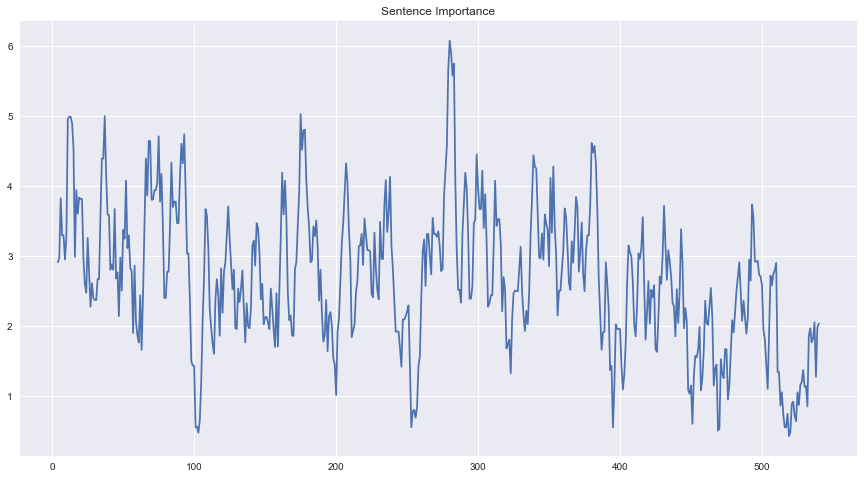

In [58]:
df['score'].rolling(window=5).apply(lambda x : np.sum(x)).plot(figsize=(15,8),title='Sentence Importance');

In [31]:
df.sort_values(by='score',ascending=False,inplace=True)

In [32]:
print('Most Important Sentence:\n',df['sentence'].values[0])

Most Important Sentence:
 Many of us have campaigned on the same core promises: to defend American jobs and demand fair trade for American workers; to rebuild and revitalize our nation’s infrastructure; to reduce the price of healthcare and prescription drugs; to create an immigration system that is safe, lawful, modern, and secure; and to pursue a foreign policy that puts America’s interests first.


In [33]:
print('Least Important Sentence:',df['sentence'].values[-2:-1])

Least Important Sentence: ['This is not an option.\xa0 ']


# Sentiment of the President

In [34]:
from textblob import TextBlob

In [35]:
df['polarity'] = df['sentence'].apply(lambda x :TextBlob(x).sentiment.polarity)
df.sort_index(ascending=True,inplace=True)

In [36]:
df.tail()

,sentence,words,score,polarity
536,And God bless America.,"[god, bless, america]",0.317308,0.00
537,Thank you very much.,[thank],0.298077,0.26
538,Thank you.,[thank],0.298077,0.00
539,(Applause.),[applause],1.000000,0.00
540,END 10:29 P.M. EST,"[end, 10:29, p.m., est]",0.125000,0.00


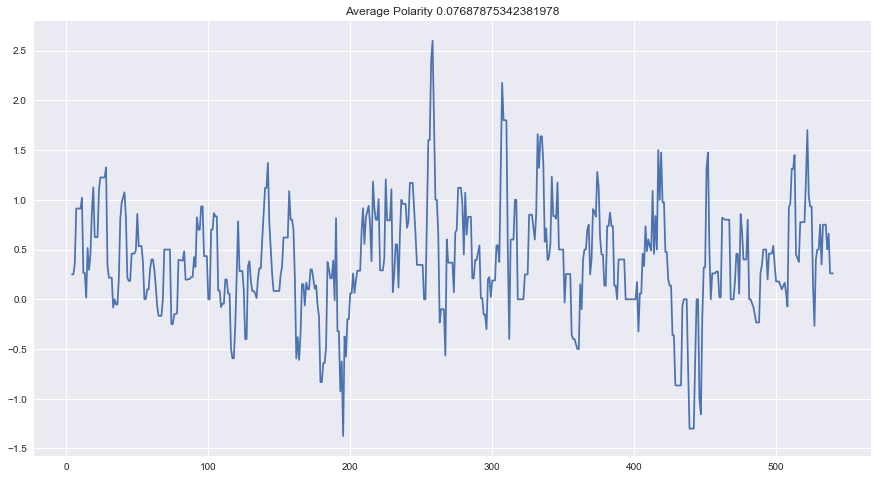

In [37]:
df['polarity'].rolling(window=5).apply(lambda x : np.sum(x)).plot(figsize=(15,8),
                                                                  title='Average Polarity ' + str(df['polarity'].mean()));

In [38]:
print('Most positive sentences')
idx = df['polarity']==df['polarity'].max()
print(df.loc[idx,'sentence'].values)

Most positive sentences
['It will be deployed in the areas identified by the border agents as having the greatest need.\xa0 '
 'Joining Melania in the gallery this evening is a very brave 10-year-old girl, Grace Eline.\xa0 '
 'The opposing side is also very happy to be negotiating.\xa0 '
 'Here tonight, we have legislators from across this magnificent republic.\xa0 ']


In [39]:
print('Most negative sentences')
idx = df['polarity']==df['polarity'].min()
print(df.loc[idx,'sentence'].values)

Most negative sentences
['No one should ever have to suffer the horrible heartache that they have had to endure.'
 'Just months ago, 11 Jewish-Americans were viciously murdered in an anti-Semitic attack on the Tree of Life synagogue in Pittsburgh.\xa0 ']
